In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import random
import datetime

from tqdm import tqdm_notebook as tqdm

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing

import lightgbm as lgb

In [4]:
path = './ashrae-energy-prediction'
# Input data files are available in the "./" directory.
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./ashrae-energy-prediction\building_metadata.csv
./ashrae-energy-prediction\sample_submission.csv
./ashrae-energy-prediction\test.csv
./ashrae-energy-prediction\train.csv
./ashrae-energy-prediction\weather_test.csv
./ashrae-energy-prediction\weather_train.csv


In [5]:
%%time
# unimportant features (see importance below)
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source='train', path=path):
    ''' load and merge all tables '''
    assert source in ['train', 'test']
    
    building = pd.read_csv(f'{path}/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    weather  = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'],
                                                           dtype={'site_id':np.uint8, 'air_temperature':np.float16,
                                                                  'cloud_coverage':np.float16, 'dew_temperature':np.float16,
                                                                  'precip_depth_1_hr':np.float16},
                                                           usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}/{source}.csv', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

# load and display some samples
train = load_data('train')
train.sample(7)

Wall time: 18 s


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
13662208,1438,2,2016-09-06 08:00:00,421.5960,15,Education,108971,1990.0,NaN,10.601562,0.0,10.000000,NaN
14441026,65,0,2016-09-20 04:00:00,174.7350,0,Lodging/residential,53130,2001.0,NaN,23.906250,NaN,22.796875,-1.0
8348802,966,1,2016-06-03 11:00:00,1400.1600,9,Education,393530,NaN,NaN,18.906250,0.0,17.796875,0.0
12824491,1081,0,2016-08-22 09:00:00,14.8930,13,Manufacturing/industrial,11470,NaN,NaN,17.203125,0.0,11.703125,0.0
11008149,816,0,2016-07-20 17:00:00,1.9583,8,Entertainment/public assembly,356,NaN,1.0,33.312500,4.0,22.203125,0.0
14928485,378,0,2016-09-28 19:00:00,70.6300,3,Public services,35241,1978.0,NaN,20.593750,NaN,19.406250,3.0
10777956,765,0,2016-07-16 15:00:00,171.2170,6,Entertainment/public assembly,58562,NaN,NaN,28.906250,0.0,20.593750,0.0


In [6]:
test = load_data('test')
test.sample(7)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
13333485,13333485,649,0,2017-02-25 14:00:00,4,Education,116121,1996.0,10.0,5.601562,4.0,3.900391,0.0
25919193,25919193,1029,0,2017-04-16 21:00:00,11,Education,152559,NaN,NaN,11.000000,NaN,10.000000,19.0
11366982,11366982,537,0,2018-03-26 08:00:00,3,Education,73200,1959.0,NaN,2.199219,NaN,-1.099609,0.0
29749710,29749710,1078,1,2018-02-10 20:00:00,13,Entertainment/public assembly,80438,NaN,NaN,-10.601562,0.0,-18.906250,0.0
8709957,8709957,519,0,2017-02-15 06:00:00,3,Public services,461647,1976.0,NaN,4.398438,8.0,-2.199219,0.0
7478141,7478141,175,0,2018-08-19 07:00:00,2,Education,111635,1989.0,NaN,33.312500,NaN,18.906250,0.0
32775352,32775352,1268,3,2017-03-31 23:00:00,14,Office,43007,NaN,NaN,5.601562,NaN,5.000000,13.0


In [7]:
print(f'Training from {train.timestamp.min()} to {train.timestamp.max()}, and predicting from {test.timestamp.min()} to {test.timestamp.max()}')

Training from 2016-01-01 00:00:00 to 2016-12-31 23:00:00, and predicting from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

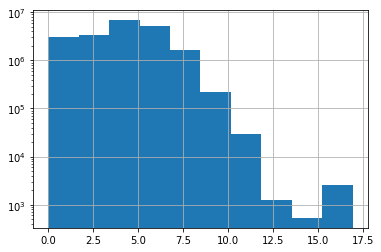

In [8]:
# target's log-log histogram:
ax = np.log1p(train.meter_reading).hist()
ax.set_yscale('log')

# describe raw values first
train.meter_reading.describe()

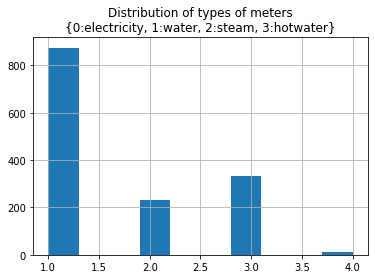

In [9]:
# check the distribution in the types of meters
meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{1:electricity, 2:water, 3:steam, 4:hotwater}') # from the official starter kernel
_ = meters.hist()
# from the graphs it looks like steam and hotwater are reversed (e.g.: 3:steam, 2:hotwater) 
# but that shouldn't make any difference to the model

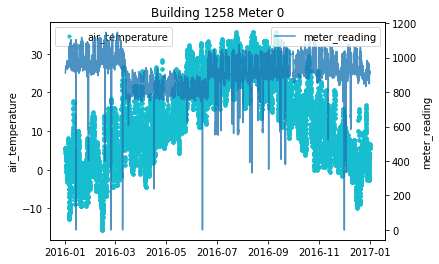

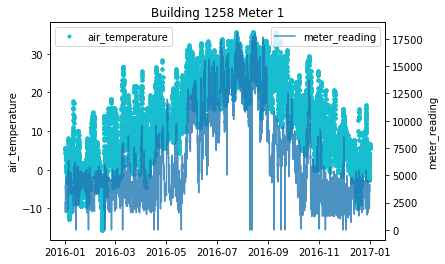

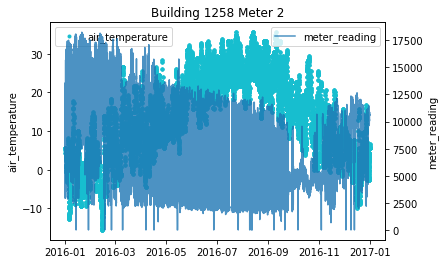

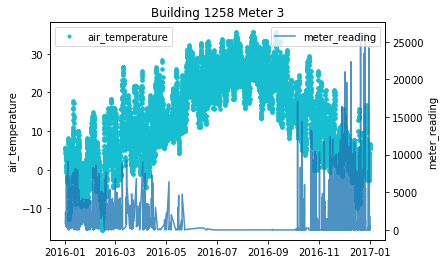

In [10]:
# display a single time series(notice measurement errors and discontinuities)
building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

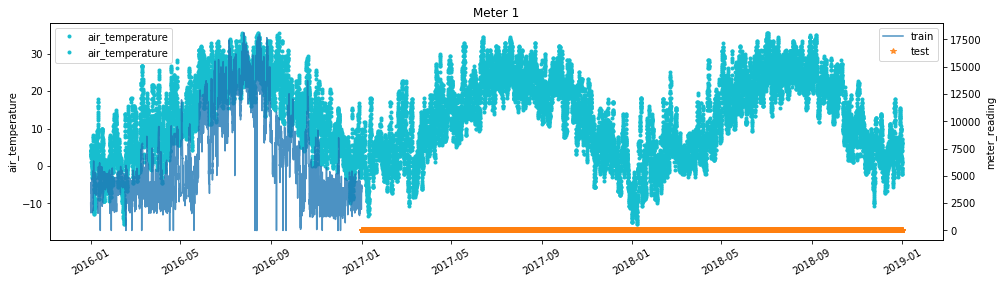

In [11]:
# now let's see what's the expected prediction in the test set for the same building
meter = 1 # pick a meter

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same train sample as above

test['meter_reading'] = 0.0
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]  # and the same meter in the test set

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Meter {meter}')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

# plot training sample
dates = matplotlib.dates.date2num(train_sample['timestamp'])
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

# plot test sample
dates = matplotlib.dates.date2num(test_sample['timestamp'])
ax2.plot_date(dates, test_sample['meter_reading'], '*', label='test', alpha=0.8)
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')

del train_sample; del test_sample; del dates

In [15]:
# some feature stats
train.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,11390735.0,2.011596e+07,16467077.0
mean,7.992780e+02,6.624412e-01,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,0.000000e+00,0.0,0.000000e+00,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890625e+01,0.0,-3.500000e+01,-1.0
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.601562e+00,0.0,0.000000e+00,0.0
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670312e+01,0.0,8.898438e+00,0.0
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.409375e+01,4.0,1.609375e+01,0.0
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.718750e+01,9.0,2.609375e+01,343.0


In [16]:
# the counts above expose the missing data (Should we drop or refill the missing data?)
print("Ratio of available data (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

Ratio of available data (not NAN's):


building_id          1.000000
meter                1.000000
timestamp            1.000000
meter_reading        1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.400100
floor_count          0.173472
air_temperature      0.995219
cloud_coverage       0.563449
dew_temperature      0.995047
precip_depth_1_hr    0.814553
dtype: float64

In [17]:
# Is the same happening in the test set? Yes
print("Ratio of available data (not NAN's):")
test.count()/len(test)

Ratio of available data (not NAN's):


row_id               1.000000
building_id          1.000000
meter                1.000000
timestamp            1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.410084
floor_count          0.173950
air_temperature      0.994678
cloud_coverage       0.531336
dew_temperature      0.993745
precip_depth_1_hr    0.812901
meter_reading        1.000000
dtype: float64

In [18]:
# we can refill with averages
train.loc[:, data_ratios < 1.0].mean()

year_built           1968.276736
floor_count             4.184848
air_temperature        15.987972
cloud_coverage          1.900423
dew_temperature         7.747397
precip_depth_1_hr       0.796416
dtype: float64

In [19]:
## Preprocess data
class ASHRAE3Preprocessor(object):
    @classmethod
    def fit(cls, df, data_ratios=data_ratios):
        cls.avgs = df.loc[:,data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])

    @classmethod
    def transform(cls, df):
        df = df.fillna(cls.avgs) # refill NAN with averages
        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels

        # expand datetime into its components
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        df['day'] = np.uint8(df['timestamp'].dt.day)
        df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        
        # remove redundant columns
        for col in df.columns:
            if col in ['timestamp', 'row_id']:
                del df[col]
    
        # extract target column
        if 'meter_reading' in df.columns:
            df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors

        return df
        
ASHRAE3Preprocessor.fit(train)

In [20]:
train = ASHRAE3Preprocessor.transform(train)
train.sample(7)

,building_id,meter,meter_reading,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,year
19391953,1326,0,4.891664,15,6,10.757812,62,4,-8.296875,1.900391,-10.601562,-1.000000,10,17,5,12,16
4807036,1332,1,4.793449,15,0,10.765625,12,4,16.093750,1.900391,11.101562,0.796387,11,1,4,4,16
11934972,562,0,6.536126,3,0,12.367188,113,4,24.406250,1.900391,23.296875,-1.000000,8,6,5,8,16
6676504,96,0,0.000000,0,4,12.210938,106,4,20.593750,8.000000,18.296875,10.000000,18,4,2,5,16
12209137,102,0,4.983442,0,6,9.671875,83,4,24.406250,4.000000,22.796875,0.000000,8,11,3,8,16
9635095,1261,0,5.181081,14,6,10.664062,68,4,18.296875,0.000000,12.796875,0.000000,7,26,6,6,16
11563961,739,0,2.906901,5,0,11.828125,66,2,19.000000,1.900391,12.000000,0.796387,16,30,5,7,16


In [21]:
train.dtypes

building_id           uint16
meter                  uint8
meter_reading        float32
site_id                uint8
primary_use            uint8
log_square_feet      float16
year_built             uint8
floor_count            uint8
air_temperature      float16
cloud_coverage       float16
dew_temperature      float16
precip_depth_1_hr    float16
hour                   uint8
day                    uint8
weekday                uint8
month                  uint8
year                   uint8
dtype: object

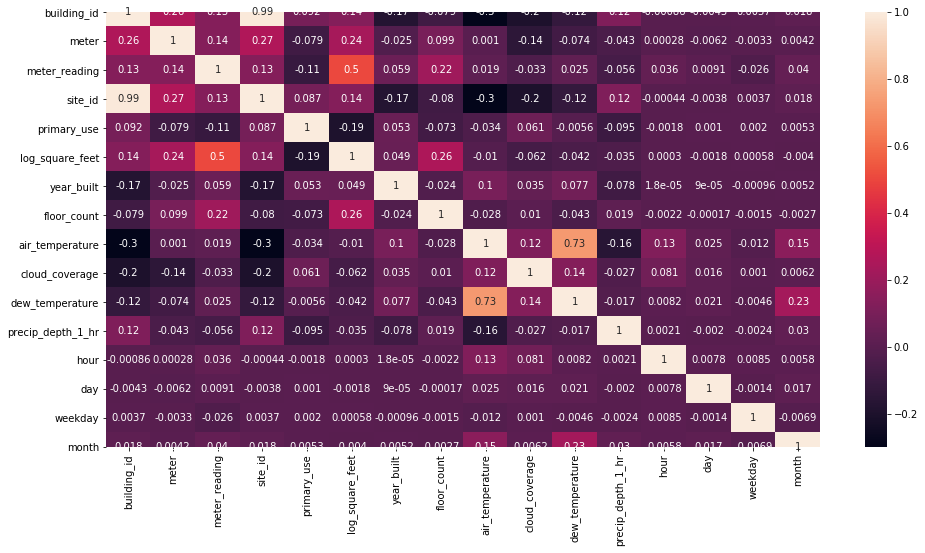

In [23]:
## Feature ranked correlation

#%%time
fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
corr = train[[col for col in train.columns if col != 'year']].sample(100100).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

In [24]:
## Train K folds
# force the model to use the weather data instead of dates, to avoid overfitting to the past history
features = [col for col in train.columns if col not in [target, 'year', 'month', 'day']]

In [25]:
folds = 4
seed = 42
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
# oof_pred = np.zeros(train.shape[0])  # out of fold predictions
models = []

## stratify data by building_id
for tr_idx, val_idx in tqdm(kf.split(train, train['building_id']), total=folds):
    def fit_regressor(tr_idx, val_idx):
        tr_x, tr_y = train[features].iloc[tr_idx], train[target][tr_idx]
        vl_x, vl_y = train[features].iloc[val_idx], train[target][val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  
        clf = lgb.LGBMRegressor(n_estimators=6000,
                                learning_rate=0.28,
                                feature_fraction=0.9,
                                subsample=0.2,  # batches of 20% of the data
                                subsample_freq=1,
                                num_leaves=20,
                                metric='rmse')
        clf.fit(tr_x, tr_y,
                eval_set=[(vl_x, vl_y)],
                early_stopping_rounds=50,
                verbose=200)
#         oof_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
        return clf
    clf = fit_regressor(tr_idx, val_idx)
    models.append(clf)
#     break ### TODO: remove to run next folds
    
gc.collect()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


{'train size': 15162075, 'eval size': 5054025}
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.18063
[400]	valid_0's rmse: 1.09067
[600]	valid_0's rmse: 1.04393
[800]	valid_0's rmse: 1.01582
[1000]	valid_0's rmse: 0.997557
[1200]	valid_0's rmse: 0.981333
[1400]	valid_0's rmse: 0.968805
[1600]	valid_0's rmse: 0.958793
[1800]	valid_0's rmse: 0.949921
[2000]	valid_0's rmse: 0.941998
[2200]	valid_0's rmse: 0.936293
[2400]	valid_0's rmse: 0.929928
[2600]	valid_0's rmse: 0.924962
[2800]	valid_0's rmse: 0.919558
[3000]	valid_0's rmse: 0.91517
[3200]	valid_0's rmse: 0.912427
[3400]	valid_0's rmse: 0.90908
[3600]	valid_0's rmse: 0.905939
[3800]	valid_0's rmse: 0.902792
[4000]	valid_0's rmse: 0.899195
[4200]	valid_0's rmse: 0.896818
[4400]	valid_0's rmse: 0.894673
[4600]	valid_0's rmse: 0.892591
[4800]	valid_0's rmse: 0.890527
[5000]	valid_0's rmse: 0.888613
[5200]	valid_0's rmse: 0.887361
[5400]	valid_0's rmse: 0.885611
[5600]	valid_0's rmse: 0.884154
[5800]

712

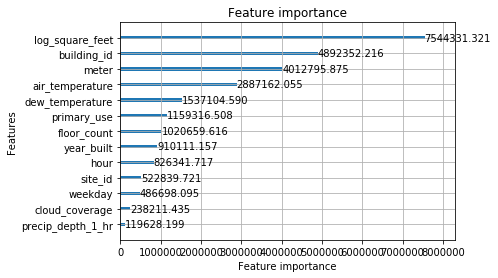

In [26]:
## Feature importance
_ = lgb.plot_importance(models[0], importance_type='gain')

In [27]:
# calculate the mean feature importance, so that we can update 'unimportant_cols' above
feature_importance = np.mean([m._Booster.feature_importance(importance_type='gain') for m in models], axis=0)
sorted(zip(feature_importance, train.columns), reverse=True)

[(7539650.8328870535, 'primary_use'),
 (4808902.502748311, 'building_id'),
 (4132174.462712109, 'meter'),
 (2944737.99902457, 'floor_count'),
 (1513851.9280676842, 'cloud_coverage'),
 (1093122.1339169145, 'site_id'),
 (1039351.6942455769, 'year_built'),
 (921797.2840567827, 'log_square_feet'),
 (819074.089797616, 'precip_depth_1_hr'),
 (497405.840831697, 'meter_reading'),
 (468440.3361427188, 'hour'),
 (226480.1998913288, 'air_temperature'),
 (121516.2655056119, 'dew_temperature')]

In [28]:
## Check prediction
# load and pre-process test data
test = ASHRAE3Preprocessor.transform(test)
test.sample(7)

,building_id,meter,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,meter_reading,hour,day,weekday,month,year
2270653,145,3,1,6,9.562500,68,4,9.203125,1.900391,8.796875,0.796387,0.0,23,7,5,1,17
35885882,1317,0,14,1,12.101562,68,4,27.796875,1.900391,20.000000,-1.000000,0.0,0,25,0,6,18
8214021,212,1,2,0,12.695312,112,4,8.898438,0.000000,4.398438,0.000000,0.0,9,3,0,12,18
38960,2,0,0,0,8.585938,91,4,20.593750,4.000000,17.796875,0.000000,0.0,14,13,4,1,17
24976789,920,1,9,0,11.359375,68,4,21.093750,1.900391,19.406250,3.000000,0.0,3,27,3,12,18
13363870,640,0,4,1,10.500000,66,9,12.796875,0.000000,12.203125,0.000000,0.0,12,11,5,3,17
15878367,696,0,5,0,9.851562,76,2,8.000000,0.000000,7.000000,0.796387,0.0,3,19,5,5,18


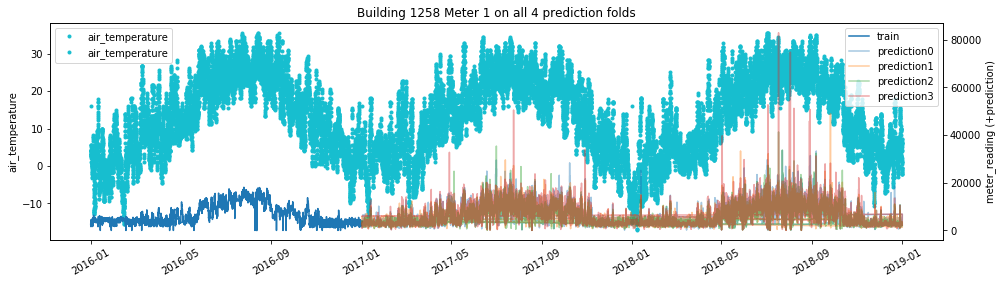

In [29]:
# now let's revisit the same meter we had initially looked at, and check the predictions for each fold
def recover_timestamp(x):
    ''' reassemble timestamp using date components '''
    return datetime.datetime.strptime(f'{x.year}-{x.month}-{x.day} {x.hour}', '%y-%m-%d %H')

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Building {building_id} Meter {meter} on all {folds} prediction folds')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same training sample as before
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]   # and the same meter in the test set

# plot training sample
dates = matplotlib.dates.date2num(train_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')
ax2.plot_date(dates, np.expm1(train_sample['meter_reading']), '-', color='tab:blue', label='train')

# plot prediction sample
dates = matplotlib.dates.date2num(test_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')
for i,model in enumerate(models):
    ax2.plot_date(dates, np.expm1(model.predict(test_sample[features])), '-', label=f'prediction{i}', alpha=0.4)

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading (+prediction)')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
_ = plt.show()

del test_sample; del train_sample
_ = gc.collect()

In [30]:
# # Check if all test buildings and meters are the same as in the training data
# train_buildings = np.unique(train[['building_id', 'meter']].values, axis=0)
# # del train; gc.collect()

# test_buildings  = np.unique(test[['building_id', 'meter']].values, axis=0)

# print(len(train_buildings), len(test_buildings))
# [b for b in test_buildings if b not in train_buildings]

## Test Inference and Submission
# split test data into batches
set_size = len(test)
iterations = 50
batch_size = set_size // iterations

print(set_size, iterations, batch_size)
assert set_size == iterations * batch_size

41697600 50 833952


In [31]:
meter_reading = []
for i in tqdm(range(iterations)):
    pos = i*batch_size
    fold_preds = [np.expm1(model.predict(test[features].iloc[pos : pos+batch_size])) for model in models]
    meter_reading.extend(np.mean(fold_preds, axis=0))

print(len(meter_reading))
assert len(meter_reading) == set_size

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



41697600


In [32]:
# save submission
submission = pd.read_csv(f'{path}/sample_submission.csv')
submission['meter_reading'] = np.clip(meter_reading, a_min=0, a_max=None) # clip min at zero
submission.to_csv('submission.csv', index=False)
submission.head(9)

,row_id,meter_reading
0,0,0.926901
1,1,0.722265
2,2,0.000000
3,3,1.823160
4,4,25.115918
5,5,0.000000
6,6,1.645665
7,7,4.690105
8,8,3.097010


count    4.169760e+07
mean     5.275151e+02
std      2.935835e+04
min      0.000000e+00
25%      1.863594e+01
50%      6.948135e+01
75%      2.218333e+02
max      7.629458e+07
Name: meter_reading, dtype: float64

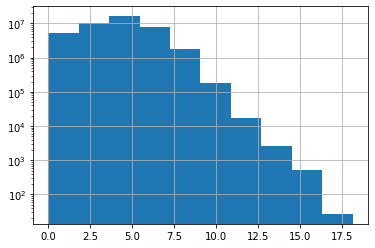

In [33]:
# prediction's log-log histogram:
plt.yscale('log')
_ = np.log1p(submission['meter_reading']).hist()

# describe raw submission
submission['meter_reading'].describe()